In [149]:
# %% Imports
from pathlib import Path
import ast
import pandas as pd
from sklearn.preprocessing import StandardScaler

from P08_feature_importances.T00_lib.classes_ml import (
    DataHandler,
    MyUtil,
    MyEval,
)
from P08_feature_importances.T00_lib.utils import check_jupyter
from P08_feature_importances.T00_lib.optuna_ml import OptunaUtil

In [150]:
BASE_DIR = Path.cwd()  # Current directory of the running file
DATA_DIR = BASE_DIR.parent / "T02_combine_features"
OPTUNA_DIR = BASE_DIR.parent / "T03_optuna"
CURRENT_DIR = BASE_DIR


In [151]:
study_info_filename = "S02_combine_study.xlsx"
study_info = pd.read_excel(OPTUNA_DIR / study_info_filename)
study_info["model_params"] = study_info["model_params"].apply(ast.literal_eval)
df = pd.read_excel(DATA_DIR / "S02_data_combined_loc.xlsx")
print(f"df.shape: {df.shape}")


df.shape: (378, 87)


In [152]:
_dfX = df.iloc[:, :-3]
_dfY = df.iloc[:, -3:]

# Extract features and targets
_X = _dfX.values
_Y = _dfY.values
print(f"_X.shape: {_X.shape}")
print(f"_Y.shape: {_Y.shape}")

# Use only the third target variable
_Y = _Y[:, 2:3]  

_X.shape: (378, 84)
_Y.shape: (378, 3)


In [153]:
# Create DataHandler instance
data_handler = DataHandler(
    _X=_X, _Y=_Y, scalerX=StandardScaler(), scalerY=StandardScaler()
)

In [154]:
# df_arr = []
# for idx, study in study_info.iterrows():
import shap


idx = 1
study = study_info.iloc[idx]
random_state = study["random_state"]
test_size = study["test_size"]
model = study["model"]
model_params = study["model_params"]

print(
    f"Processing study {idx + 1}/{len(study_info)}: model={model}, random_state={random_state}, test_size={test_size}"
)
data_handler.split_and_scale(random_state=random_state, test_size=test_size)
X_train, Y_train = data_handler.get_train()
dfX_train = pd.DataFrame(X_train, columns=_dfX.columns)
dfY_train = pd.DataFrame(Y_train, columns=["Center"])
reg = OptunaUtil.get_model(model_name=model, **model_params)
reg.fit(dfX_train, dfY_train)


Processing study 2/2: model=XGBR, random_state=1, test_size=0
No test set, using all data for training.


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.6798872582107739,
                                            colsample_bynode=None,
                                            colsample_bytree=0.49665415678116653,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,
                                            gamma=1.4092422497476265,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.20651425578959234,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=1.6172900811143154,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=122, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [155]:
reg.estimator.fit(dfX_train, dfY_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6798872582107739, colsample_bynode=None,
             colsample_bytree=0.49665415678116653, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=1.4092422497476265, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.20651425578959234,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1.6172900811143154, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=122,
             n_jobs=None, num_parallel_tree=None, ...)

In [156]:
explainer = shap.TreeExplainer(reg.estimator, _dfX)
shap_values = explainer(_dfX)

In [157]:
shap_values.feature_names

['sample_no',
 'R',
 'W',
 'D',
 'position',
 'location',
 'Fx_location',
 'Fy_location',
 'Fz_location',
 'Mz_location',
 'loc_idx',
 'loc_time',
 'Fx__dwell__fft_coefficient__attr_"abs"__coeff_11',
 'Fx__dwell__ar_coefficient__coeff_0__k_10',
 'Fx__dwell__variation_coefficient',
 'Fx__dwell__quantile__q_0.7',
 'Fx__dwell__fft_coefficient__attr_"real"__coeff_62',
 'Fx__dwell__fft_coefficient__attr_"real"__coeff_42',
 'Fx__dwell__partial_autocorrelation__lag_6',
 'Fx__dwell__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
 'Fx__dwell__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
 'Fy__dwell__fft_coefficient__attr_"real"__coeff_71',
 'Fy__dwell__fft_coefficient__attr_"abs"__coeff_59',
 'Fy__dwell__fft_coefficient__attr_"abs"__coeff_46',
 'Fy__dwell__last_location_of_minimum',
 'Fy__dwell__first_location_of_minimum',
 'Fy__dwell__fft_coefficient__attr_"real"__coeff_16',
 'Fy__dwell__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
 'Fy__dwell__aut

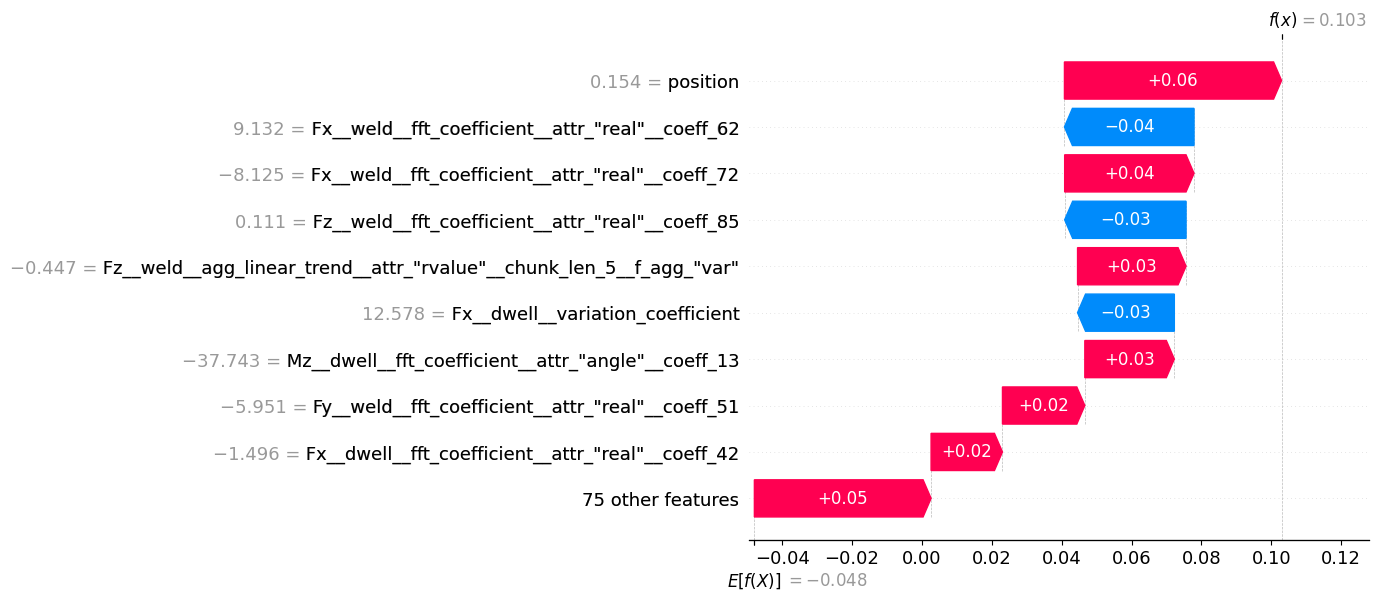

In [158]:
shap.plots.waterfall(shap_values[0])

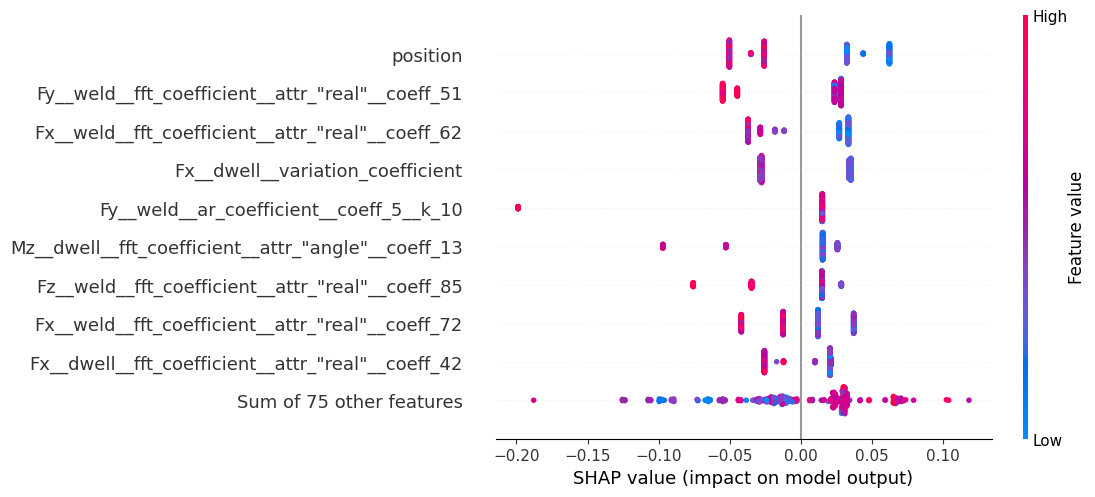

In [159]:
shap.plots.beeswarm(shap_values)

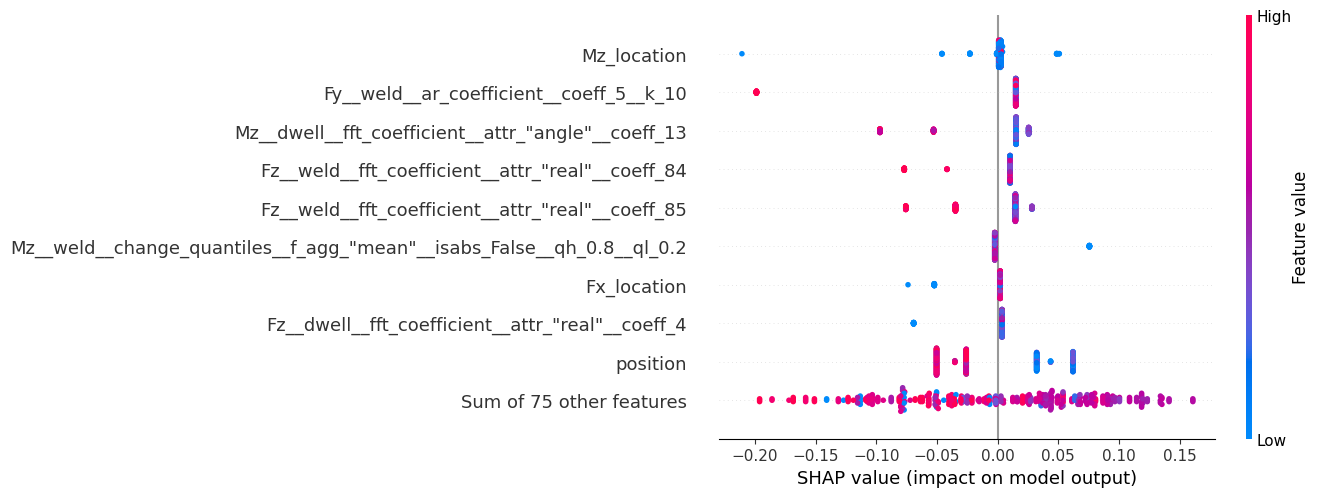

In [160]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

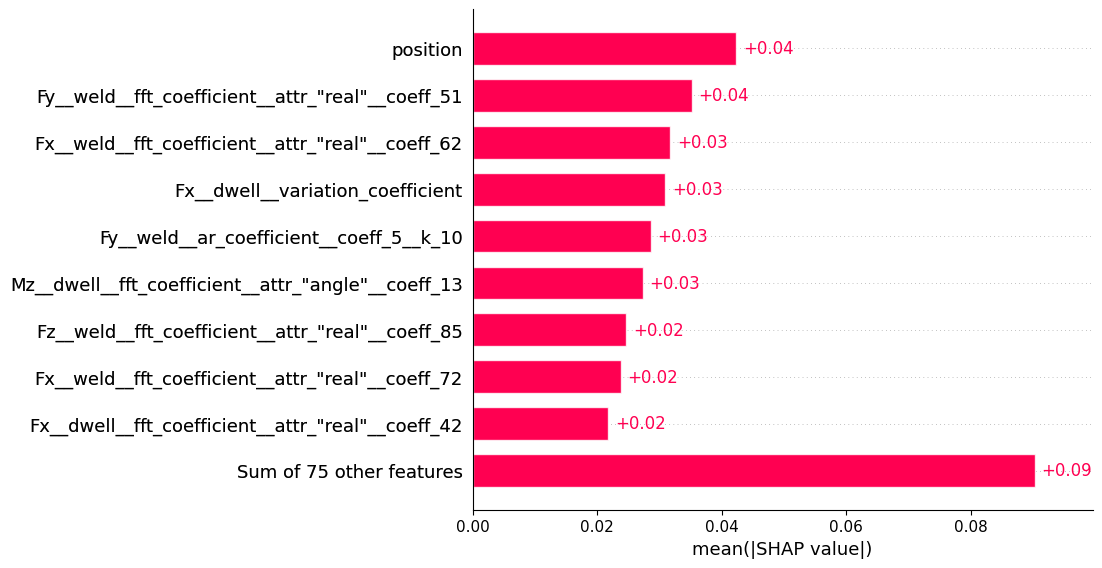

In [161]:
shap.plots.bar(shap_values)

C:\Users\admin\AppData\Local\Temp\ipykernel_21268\3125441045.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=_dfX.columns)


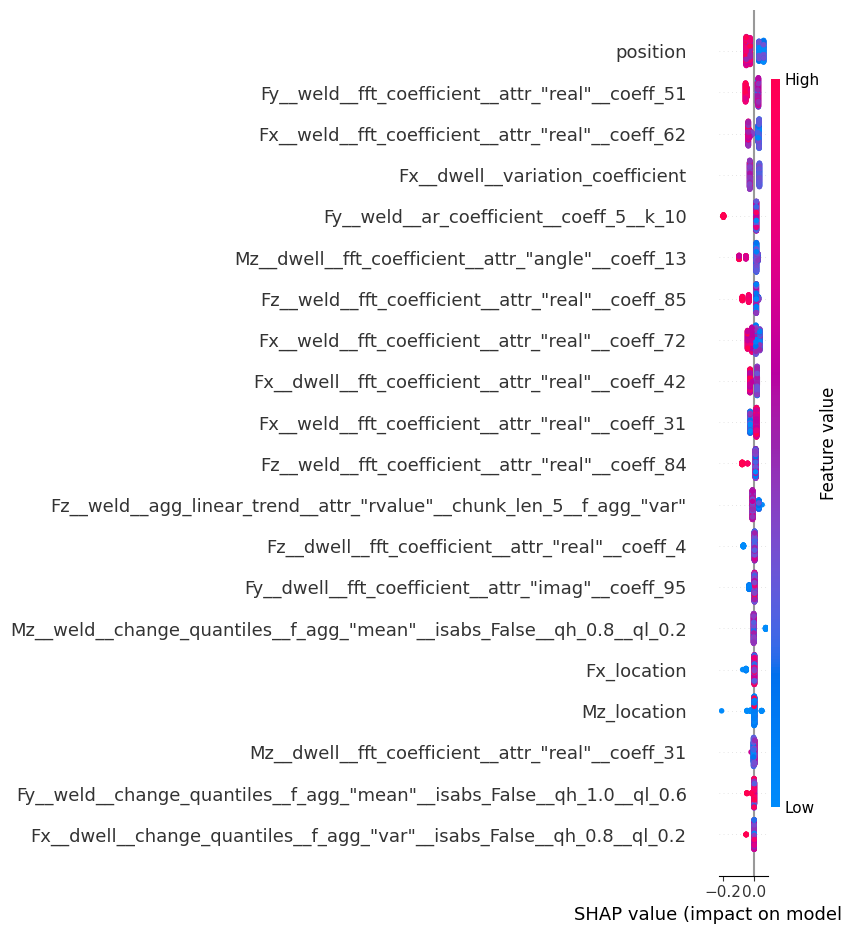

In [162]:
shap.summary_plot(shap_values, feature_names=_dfX.columns)

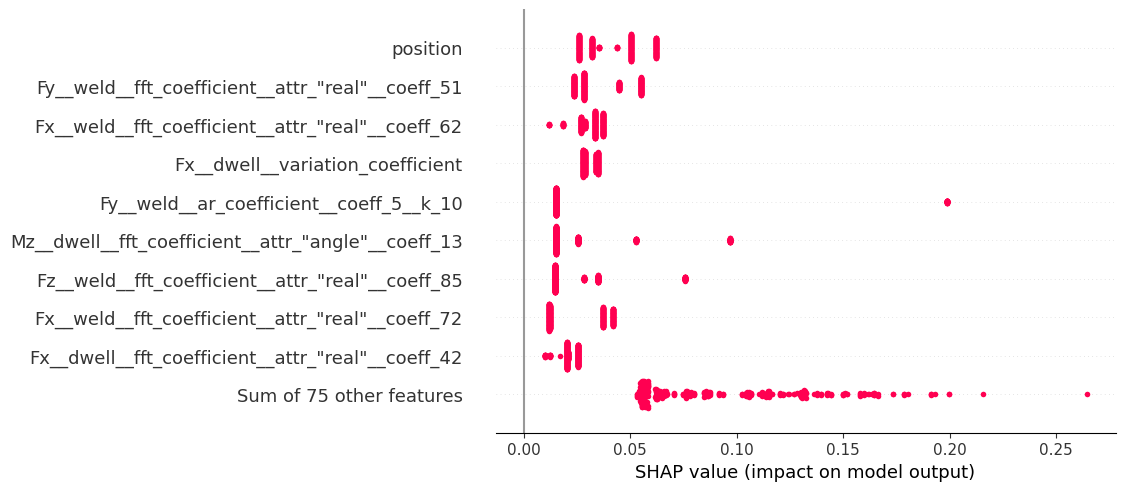

In [163]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

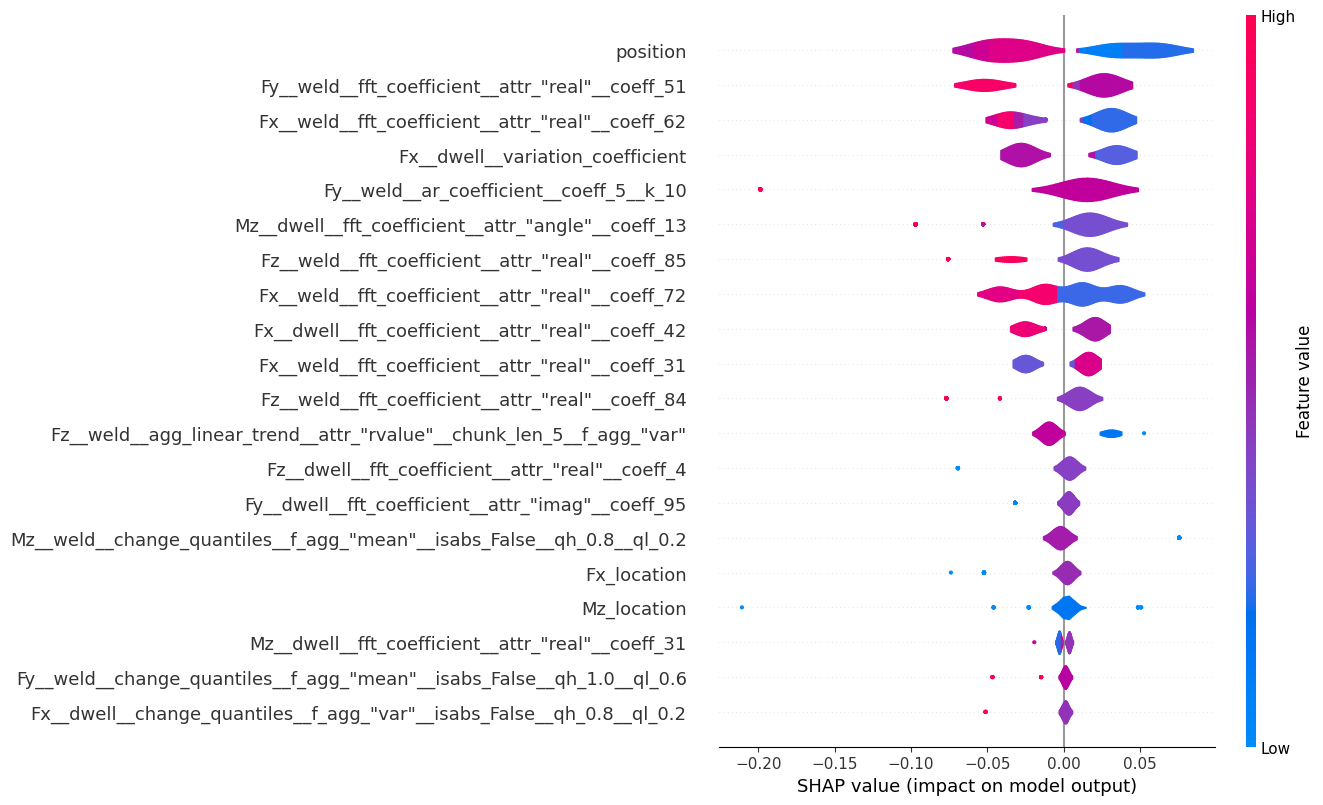

In [164]:
shap.plots.violin(shap_values)

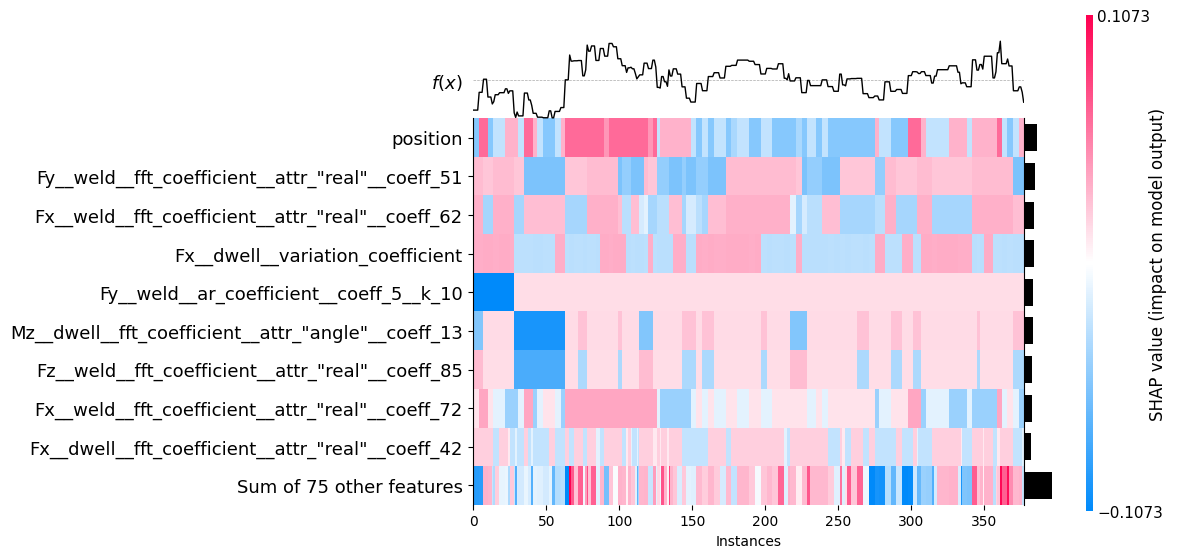

<Axes: xlabel='Instances'>

In [165]:
shap.plots.heatmap(shap_values)

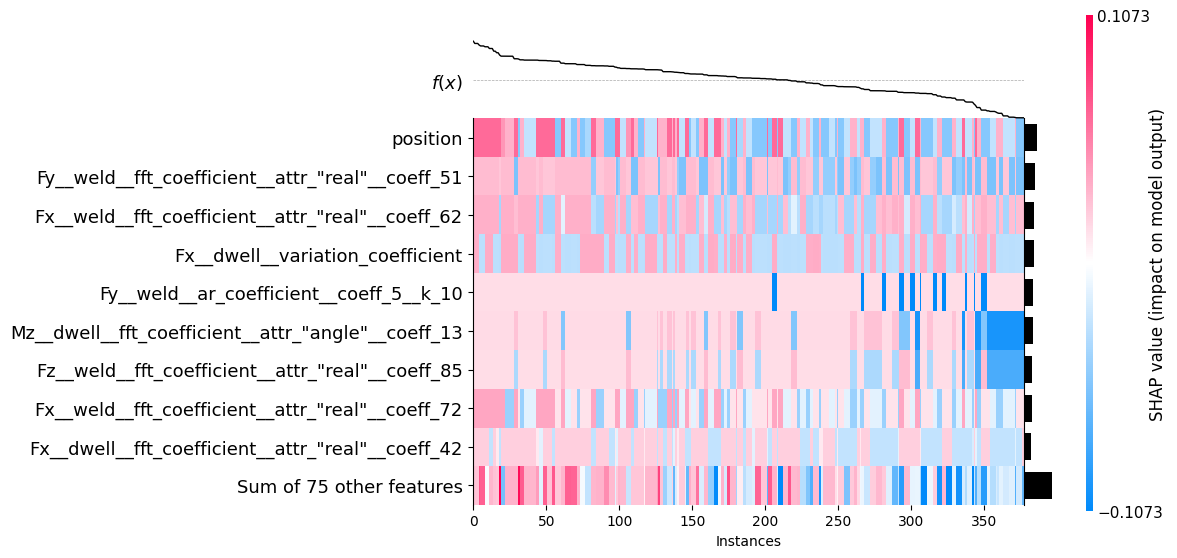

<Axes: xlabel='Instances'>

In [166]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))